# Velocity, distance and altitude

## Theory

### Velocity at time $t$

$\large v_{t} = g_{0} * (I_{sp} * \ln\frac{m_{0}}{m_{t}} - cos(\theta)*t) $

$v_{t}$ - velocity at time t in $\frac{m}{s}$

$g_{0}$ - surface gravity (exactly $9.80665\frac{m}{s}$)

$I_{sp}$ - specific impulse in $s$

$m_{0}$ - initial total mass, including propellant, a.k.a. "wet mass" in $kg$

$m_{t}$ - total mass at time t in $kg$

$\theta$ - flight path angle relative to local vertical in $rad$

$t$ - time in $s$

### Distance at time t

$\large d_{t} = \sum_{i=1}^{t}v_{i}$

$d_{t}$ - distance at time t in $m$

In [1]:
import numpy as np

In [2]:
def velocity_at_t(g, isp, m_0, m_t, t, theta):
    return g * (isp * np.log(m_0 / m_t) - np.cos(theta) * t)

### Fuel mass at time $t$

$\large m_{t} = m_{0} - (\dot {m} * t)$

$\dot {m}_i$ - fuel consumption in $\frac{kg}{s}$

In [3]:
def mass_at_t(m_0, m_dot, t):
    return m_0 - (m_dot * t)

### Fuel consumption

$\large \dot m = \frac {\sum_{i=1}^{n} F_{T_{i}}}{I_{sp} * g_0}$

$F_{T_i}$ - thrust of each engine in $N$ (newton)

In [4]:
def fuel_consumption(thrust, isp, g):
    return thrust / (isp * g)

## Example - launching Falcon 9 into LEO

<img src="https://upload.wikimedia.org/wikipedia/commons/2/28/Falcon_9_logo_by_SpaceX.png" width="100">

| Stage | Engines           | $I_{sp}$ | Thrust | Dry mass  | Fuel       | Fuel volume | Burn time |
| ----- | ----------------- | -------- | ------ | --------- | ---------- | ----------- | --------- |
| 1     | 9 x Merlin 1D+    | 282 s    | 845 kN | 25,600 kg | LOx + RP-1 | 398,887 L   | 162 s     |
| 2     | 1 x Merlin 1D+Vac | 348 s    | 934 kN | 4,000 kg  | LOx + RP-1 | 108,185 L   | 346 s     |


In [5]:
import json

In [6]:
with open('falcon_9_v1.2.json') as fp:
    specs = json.load(fp)

In [7]:
dry_mass_2nd_stage = specs['stages'][1]['dry_mass']
wet_mass_2nd_stage = dry_mass_2nd_stage + specs['stages'][1]['fuel_mass']

# dry mass of the 1st stage with 2nd stage on top
dry_mass_1st_stage = specs['stages'][0]['dry_mass'] + wet_mass_2nd_stage
# wet mass of the 1st stage with 2nd stage on top
wet_mass_1st_stage = dry_mass_1st_stage + specs['stages'][0]['fuel_mass']

### 1. Launch

Why are rockets launched vertically?

Let's check how the flight path angle affects how quickly we can cross Karman line.

In [8]:
# fuel consumption for 9 Merlin 1D+ engines in kg/s
G_0 = 9.80665
m_dot_1st_stage = fuel_consumption(9 * specs['stages'][0]['thrust'], specs['stages'][0]['isp'], G_0)

# fuel consumption for 9 Merlin 1D+Vac engines in kg/s 
# (assuming the engine is already at the altitude of 100km, operating in a near-vacuum environment)
G_100 = 9.50722802366864
m_dot_2nd_stage = fuel_consumption(specs['stages'][1]['thrust'], specs['stages'][1]['isp'], G_100)

In [9]:
t_1st_stage = np.arange(specs['stages'][0]['burn_time'])
t_2nd_stage = np.arange(specs['stages'][1]['burn_time'])

mass_t_1st_stage = mass_at_t(wet_mass_1st_stage, m_dot_1st_stage, t_1st_stage)
mass_t_2nd_stage = mass_at_t(wet_mass_2nd_stage, m_dot_2nd_stage, t_2nd_stage)

In [10]:
degrees = np.array([0, 30, 45, 60, 90])
theta = np.vstack(degrees * np.pi / 180)

# velocity
v_1st_stage = velocity_at_t(G_0, specs['stages'][0]['isp'], wet_mass_1st_stage, mass_t_1st_stage, t_1st_stage, theta)
# flight path distance
d_1st_stage = v_1st_stage.cumsum(axis=1)
# vertial distance (altitude)
d_v_1st_stage = np.cos(theta) * d_1st_stage
# horizontal distance
d_h_1st_stage = np.sin(theta) * d_1st_stage

In [11]:
import matplotlib.pyplot as plt
import matplotlib

In [12]:
max(d_h_1st_stage[0][-1], d_v_1st_stage[0][-1])

113800.47342109412

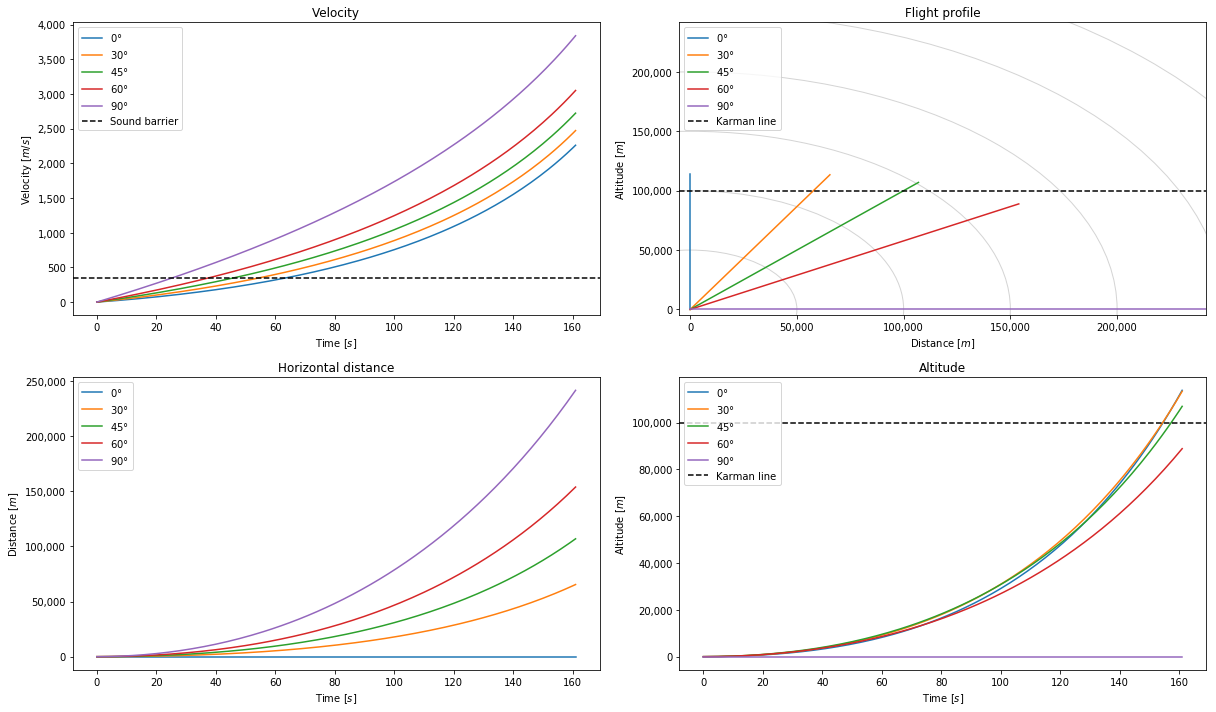

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(17, 10))

formatter = matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))

for i, degree in enumerate(degrees):
    label = '${:}°$'.format(degree)
    ax[0][0].plot(t_1st_stage, v_1st_stage[i], label=label)
    ax[0][1].plot(d_h_1st_stage[i], d_v_1st_stage[i], label=label)
    ax[1][0].plot(t_1st_stage, d_h_1st_stage[i], label=label)
    ax[1][1].plot(t_1st_stage, d_v_1st_stage[i], label=label)
    
ax[0][0].get_yaxis().set_major_formatter(formatter)
ax[0][0].axhline(343, color='k', linestyle='--', label='Sound barrier')
ax[0][0].set_title('Velocity')
ax[0][0].set_xlabel('Time [$s$]')
ax[0][0].set_ylabel('Velocity [$m/s$]')
ax[0][0].legend(loc='upper left')

# add distance arcs
for r in range(0, 350000, 50000):
    p = matplotlib.patches.Circle((0, 0), r, color='#aaaaaa', alpha=0.5, fill=False)
    ax[0][1].add_patch(p)

ax[0][1].get_xaxis().set_major_formatter(formatter)
ax[0][1].get_yaxis().set_major_formatter(formatter)
ax[0][1].axhline(100000, color='k', linestyle='--', label='Karman line')
max_dist = max(d_h_1st_stage.max(), d_v_1st_stage.max())
ax[0][1].set_xlim(-5000, max_dist)
ax[0][1].set_ylim(-5000, max_dist)
ax[0][1].set_title('Flight profile')
ax[0][1].set_xlabel('Distance [$m$]')
ax[0][1].set_ylabel('Altitude [$m$]')
ax[0][1].legend(loc='upper left')

ax[1][0].get_yaxis().set_major_formatter(formatter)
ax[1][0].set_title('Horizontal distance')
ax[1][0].set_xlabel('Time [$s$]')
ax[1][0].set_ylabel('Distance [$m$]')
ax[1][0].legend(loc='upper left')  

ax[1][1].get_yaxis().set_major_formatter(formatter)
ax[1][1].axhline(100000, color='k', linestyle='--', label='Karman line')
ax[1][1].set_title('Altitude')
ax[1][1].set_xlabel('Time [$s$]')
ax[1][1].set_ylabel('Altitude [$m$]')
ax[1][1].legend(loc='upper left')

plt.tight_layout()
plt.show();

**Observe**

- Velocity and distance is heavily affected by the flight path angle due to the gravity drag
- Assuming there is no atmophere drag, the fastest way to cross the Karman line is to launch rocket at 0~30 degrees

### 2. Orbit circularization

At the altitude of 100km atmosphere is less dense, so we can separate stages and start circularization burn.

Let's see how the flight path angle affects how fast we can create a stable, circular orbit.

In [14]:
target_v = 7800 # once we are at 100km, we need to travel with 7.8km/s to circularize the orbit

In [15]:
degrees = np.array([0, 30, 45, 60, 90])
theta = np.vstack(degrees * np.pi / 180)

# velocity
v_2nd_stage = np.vstack(v_1st_stage[:, -1]) + velocity_at_t(G_100, specs['stages'][1]['isp'], wet_mass_2nd_stage, mass_t_2nd_stage, t_2nd_stage, theta)
# flight path distance
d_2nd_stage = (v_2nd_stage.cumsum(axis=1))

# vertial distance (altitude)
d_v_2nd_stage = (np.cos(theta) * d_2nd_stage)
# horizontal distance
d_h_2nd_stage = (np.sin(theta) * d_2nd_stage)

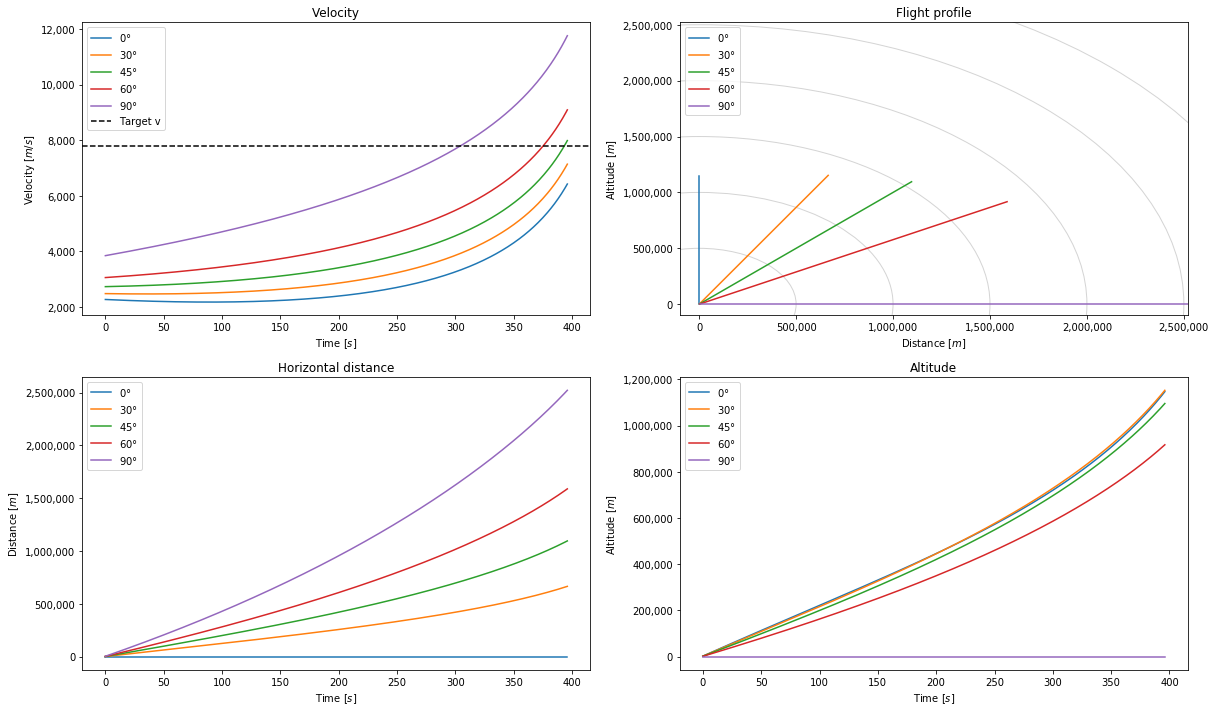

In [16]:
fig, ax = plt.subplots(2, 2, figsize=(17, 10))

formatter = matplotlib.ticker.FuncFormatter(lambda x, p: '{:,}'.format(int(x)))

for i, degree in enumerate(degrees):
    label = '${:}°$'.format(degree)
    ax[0][0].plot(t_2nd_stage, v_2nd_stage[i], label=label)
    ax[0][1].plot(d_h_2nd_stage[i], d_v_2nd_stage[i], label=label)
    ax[1][0].plot(t_2nd_stage, d_h_2nd_stage[i], label=label)
    ax[1][1].plot(t_2nd_stage, d_v_2nd_stage[i], label=label)

ax[0][0].get_yaxis().set_major_formatter(formatter)
ax[0][0].axhline(target_v, color='k', linestyle='--', label='Target v')
ax[0][0].set_title('Velocity')
ax[0][0].set_xlabel('Time [$s$]')
ax[0][0].set_ylabel('Velocity [$m/s$]')
ax[0][0].legend(loc='upper left')

# add distance arcs
for r in range(0, 3500000, 500000):
    p = matplotlib.patches.Circle((0, 0), r, color='#aaaaaa', alpha=0.5, fill=False)
    ax[0][1].add_patch(p)

ax[0][1].get_xaxis().set_major_formatter(formatter)
ax[0][1].get_yaxis().set_major_formatter(formatter)
max_dist = max(d_h_2nd_stage.max(), d_v_2nd_stage.max())
ax[0][1].set_xlim(-100000, max_dist)
ax[0][1].set_ylim(-100000, max_dist)
ax[0][1].set_title('Flight profile')
ax[0][1].set_xlabel('Distance [$m$]')
ax[0][1].set_ylabel('Altitude [$m$]')
ax[0][1].legend(loc='upper left')

ax[1][0].get_yaxis().set_major_formatter(formatter)
ax[1][0].set_title('Horizontal distance')
ax[1][0].set_xlabel('Time [$s$]')
ax[1][0].set_ylabel('Distance [$m$]')
ax[1][0].legend(loc='upper left')  

ax[1][1].get_yaxis().set_major_formatter(formatter)
ax[1][1].set_title('Altitude')
ax[1][1].set_xlabel('Time [$s$]')
ax[1][1].set_ylabel('Altitude [$m$]')
ax[1][1].legend(loc='upper left')

plt.tight_layout()
plt.show();

**Observe**

- The best way to circularize the orbit at 100km altitude is to accellerate at the angle 90°
- We should turn engines off after 300s, otherwise orbital speed will grow quickly and the orbit become eliptical (eventualy, at 11km/s we'll reach escape velocity)
- At the end of 2nd stage burn, we should be approximately 2000km from the launch pad - it agrees with what we can observe on SpaceX videos (example: https://youtu.be/xybp6zLaGx4?t=1564)
- If we continue flying vertically, we'll observe temporary decreese in velocity - engine is not powerful enough to overcome gravity drag

### Save to file

In [17]:
with open('falcon_9_vel_dist_alt.json', 'w') as fp:
    json.dump({
        "stages": [
            {
                "time": t_1st_stage.tolist(),
                "velocity": v_1st_stage.tolist(),
                "vertical_distance": d_v_1st_stage.tolist(),
                "horizontal_distance": d_h_1st_stage.tolist()
            },
            {
                "time": t_2nd_stage.tolist(),
                "velocity": v_2nd_stage.tolist(),
                "vertical_distance": d_v_2nd_stage.tolist(),
                "horizontal_distance": d_h_2nd_stage.tolist()
            }
        ]
    }, fp, indent=2)

## Sources

- http://web.mit.edu/16.unified/www/FALL/thermodynamics/notes/node103.html
- https://en.wikipedia.org/wiki/Flight_dynamics_%28spacecraft%29
- https://en.wikipedia.org/wiki/Tsiolkovsky_rocket_equation
- https://en.wikipedia.org/wiki/Gravity_drag